In [1]:
import pandas as pd 
import numpy as np 
import configparser
import os
import seaborn as sns
import plotly_express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import nltk 

from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne

config = configparser.ConfigParser()
config.read("..//env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
base_path = config['DEFAULT']['base_path']
code_dir = config['DEFAULT']['code_dir']

data_prefix = 'Maha'
out_path = f'{output_dir}/{data_prefix}'
OHCO = ['book_id','chap_id','sec_id','para_num', 'sent_num', 'token_num']


os.chdir(code_dir)
import preprocess
import bow_analysis
os.chdir(base_path + "//notebooks")

SENTS = OHCO[:5]
PARA = OHCO[:4]
SECS = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [2]:
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 108, # THIS LIMITS OUR VOCAB
    workers = 8
)

In [3]:
CORPUS = pd.read_csv(fr"{output_dir}\F2\{data_prefix}-CORPUS.csv", sep="|").set_index(OHCO)

VOCAB = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-VOCAB2.csv", sep="|").set_index('term_str')
VOCAB = VOCAB[~VOCAB.index.isna()]
VOCAB

,term_rank,index,n,n_chars,p,i,s,h,stop,stem_porter,...,n_pos,cat_pos,df,idf,dp,di,dh,dfidf,tfidf_mean,tfidf_sum
term_str,,,,,,,,,,,,,,,,,,,,,
the,1,26639,163915,3,6.803053e-02,3.877674,1.469928e+01,0.263800,1,the,...,2,"{'VB', 'DT'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
of,2,18678,129501,2,5.374750e-02,4.217659,1.860552e+01,0.226689,1,of,...,1,{'IN'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
and,3,3003,95887,3,3.979650e-02,4.651215,2.512784e+01,0.185102,1,and,...,1,{'CC'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
that,4,26637,47382,4,1.966521e-02,5.668211,5.085123e+01,0.111467,1,that,...,6,"{'RB', 'NNP', 'VBP', 'IN', 'WDT', 'DT'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
to,5,26929,43192,2,1.792621e-02,5.801786,5.578424e+01,0.104004,1,to,...,1,{'TO'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jamvunadi,30678,14683,1,9,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvunadi,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,6.657043e-06,0.000659
jamvuvan,30679,14685,1,8,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvuvan,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,3.396216e-06,0.000336
janani,30680,14693,1,6,4.150354e-07,21.200262,2.409433e+06,0.000009,0,janani,...,1,{'NN'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,2.544436e-07,0.000025


In [4]:
BAG = OHCO[:2]

docs = CORPUS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

docs = [doc for doc in docs if len(doc) > 1]
docs[:2]

[['anukramanika',
  'parva',
  'om',
  'having',
  'bowed',
  'down',
  'to',
  'narayana',
  'and',
  'nara',
  'the',
  'most',
  'exalted',
  'male',
  'being',
  'and',
  'also',
  'to',
  'the',
  'goddess',
  'saraswati',
  'must',
  'the',
  'word',
  'jaya',
  'be',
  'uttered',
  'ugrasrava',
  'the',
  'son',
  'of',
  'lomaharshana',
  'surnamed',
  'sauti',
  'wellversed',
  'in',
  'the',
  'puranas',
  'bending',
  'with',
  'humility',
  'one',
  'day',
  'approached',
  'the',
  'great',
  'sages',
  'of',
  'rigid',
  'vows',
  'sitting',
  'at',
  'their',
  'ease',
  'who',
  'had',
  'attended',
  'the',
  'twelve',
  'years',
  'sacrifice',
  'of',
  'saunaka',
  'surnamed',
  'kulapati',
  'in',
  'the',
  'forest',
  'of',
  'naimisha',
  'those',
  'ascetics',
  'wishing',
  'to',
  'hear',
  'his',
  'wonderful',
  'narrations',
  'presently',
  'began',
  'to',
  'address',
  'him',
  'who',
  'had',
  'thus',
  'arrived',
  'at',
  'that',
  'recluse',
  'abo

In [5]:
vocab = Dictionary(docs)

In [6]:
vocab

In [7]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [8]:
model.wv.vectors

array([[ 0.09258495, -0.01596045, -0.14774065, ..., -0.24869494,
        -0.42061052,  0.11411141],
       [-0.3388104 , -0.10847192, -0.5530755 , ..., -0.7030613 ,
        -0.77197266, -0.66809726],
       [-0.12566462,  0.80692893, -0.31524113, ..., -0.31234568,
        -0.04461842,  0.12093294],
       ...,
       [ 0.07209196,  0.06378703, -0.11956354, ..., -0.09018344,
        -0.046038  , -0.03403516],
       [ 0.08020236,  0.03518754, -0.07661445, ..., -0.185491  ,
        -0.19572929, -0.06133353],
       [-0.04515234,  0.0447927 ,  0.09432341, ..., -0.16715838,
        -0.10305478,  0.03321012]], dtype=float32)

In [9]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        # print(f"No - {w}")
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
the,0.092585,-0.015960,-0.147741,0.484299,0.065821,-0.250196,0.417258,-0.118769,-0.069275,0.298285,...,-0.420940,-0.111203,-0.168866,-0.794363,-0.286407,-0.291750,-0.104857,-0.248695,-0.420611,0.114111
of,-0.338810,-0.108472,-0.553075,-0.139085,0.254102,0.317544,-0.807811,-0.339884,0.102894,0.420526,...,-0.442338,-0.136835,-0.498323,-0.355710,0.454916,0.211221,0.494083,-0.703061,-0.771973,-0.668097
and,-0.125665,0.806929,-0.315241,-0.386752,0.204186,0.446024,-0.445381,-0.011812,-0.485613,0.273374,...,0.176024,0.753924,-0.158196,0.325875,0.461530,-0.281785,0.003756,-0.312346,-0.044618,0.120933
that,0.369121,0.092465,0.337643,0.020532,0.149916,-0.388197,0.163837,0.375957,0.264291,0.183740,...,-0.107505,-0.381565,-0.034455,-0.111146,-0.076087,0.662426,-0.559360,-0.043292,0.170567,-0.662656
to,-0.079469,0.103632,-0.037009,0.414929,0.467838,-0.148896,0.553383,-0.625185,-0.284848,0.944227,...,-1.361283,0.067653,0.956776,0.789658,0.374236,-0.155077,-0.310189,0.661910,0.856056,0.048817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kali,0.072092,0.063787,-0.119564,0.148424,0.076169,-0.008084,0.061658,0.228754,-0.024425,0.106813,...,0.002096,-0.046113,-0.119876,-0.021203,0.053737,0.115701,0.012514,-0.090183,-0.046038,-0.034035
shame,-0.045152,0.044793,0.094323,0.203966,0.001769,0.029862,0.183963,0.272893,-0.147793,0.000845,...,0.139034,0.097339,-0.001403,-0.015819,0.078665,0.177914,0.105518,-0.167158,-0.103055,0.033210
increase,0.013858,0.054287,0.022732,0.122557,0.077124,-0.073784,0.114512,0.196449,-0.053053,0.051939,...,0.091846,-0.012243,-0.047095,0.001694,0.032685,0.111884,-0.033190,-0.109148,-0.061011,0.043919


In [10]:
WV.to_csv(fr"{output_dir}/Word2Vec_Results/{data_prefix}-W2V.csv", sep="|")

In [11]:
PP = 108
tsne_engine = tsne(
    perplexity=PP, 
    n_components=2, 
    init='pca', 
    n_iter=2500, 
    random_state=108)

In [12]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

C:\Users\vishg\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [13]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
TSNE

,x,y
term_str,,
the,-4.834017,8.010503
of,-0.690102,-6.106524
and,-9.790867,3.536606
that,1.766060,4.165217
to,15.043788,-11.014612
...,...,...
kali,0.074638,7.585425
shame,-1.771752,-0.309379
increase,3.355985,-3.101374


In [14]:
TSNE.reset_index()[TSNE.reset_index()['term_str'].apply(lambda x: x[:3]=='div')]

,term_str,x,y
213,diverse,-15.082041,6.040706
745,divine,1.503289,7.040225
1100,division,-6.216795,-4.229189
1134,divested,1.179873,-7.656155
1295,divisions,-9.633313,6.919320


In [15]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='RB']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [16]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='JJ']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [17]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='NN']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [25]:
X = TSNE.join(VOCAB, how='left')
tplot = px.scatter(X.reset_index(), 'x', 'y', 
           title="t-SNE Reduced Plot of Word2Vec Embeddings",
        text='term_str', 
        size="dfidf",
        # color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1000)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')
tplot.write_html(base_path+"/plots/word2vec_tsne.html", include_plotlyjs='cdn', full_html=True, config={'responsive': True})

tplot

In [19]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [20]:
get_most_similar('defeat',3)

,term,sim
0,kingdom,0.613736
1,journey,0.587070
2,welfare,0.557951
3,fears,0.554701
4,protection,0.547701
5,exile,0.539816
6,lives,0.539702
7,purpose,0.533390
8,service,0.531425
9,victory,0.527021


In [21]:
complete_analogy('man', 'prince', 'woman', 5)

,term,sim
0,host,0.731611
1,princess,0.727251
2,rakshasa,0.706009
3,queen,0.688699
4,vritra,0.682558


In [22]:
import sys
sys.path.append(code_dir)
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

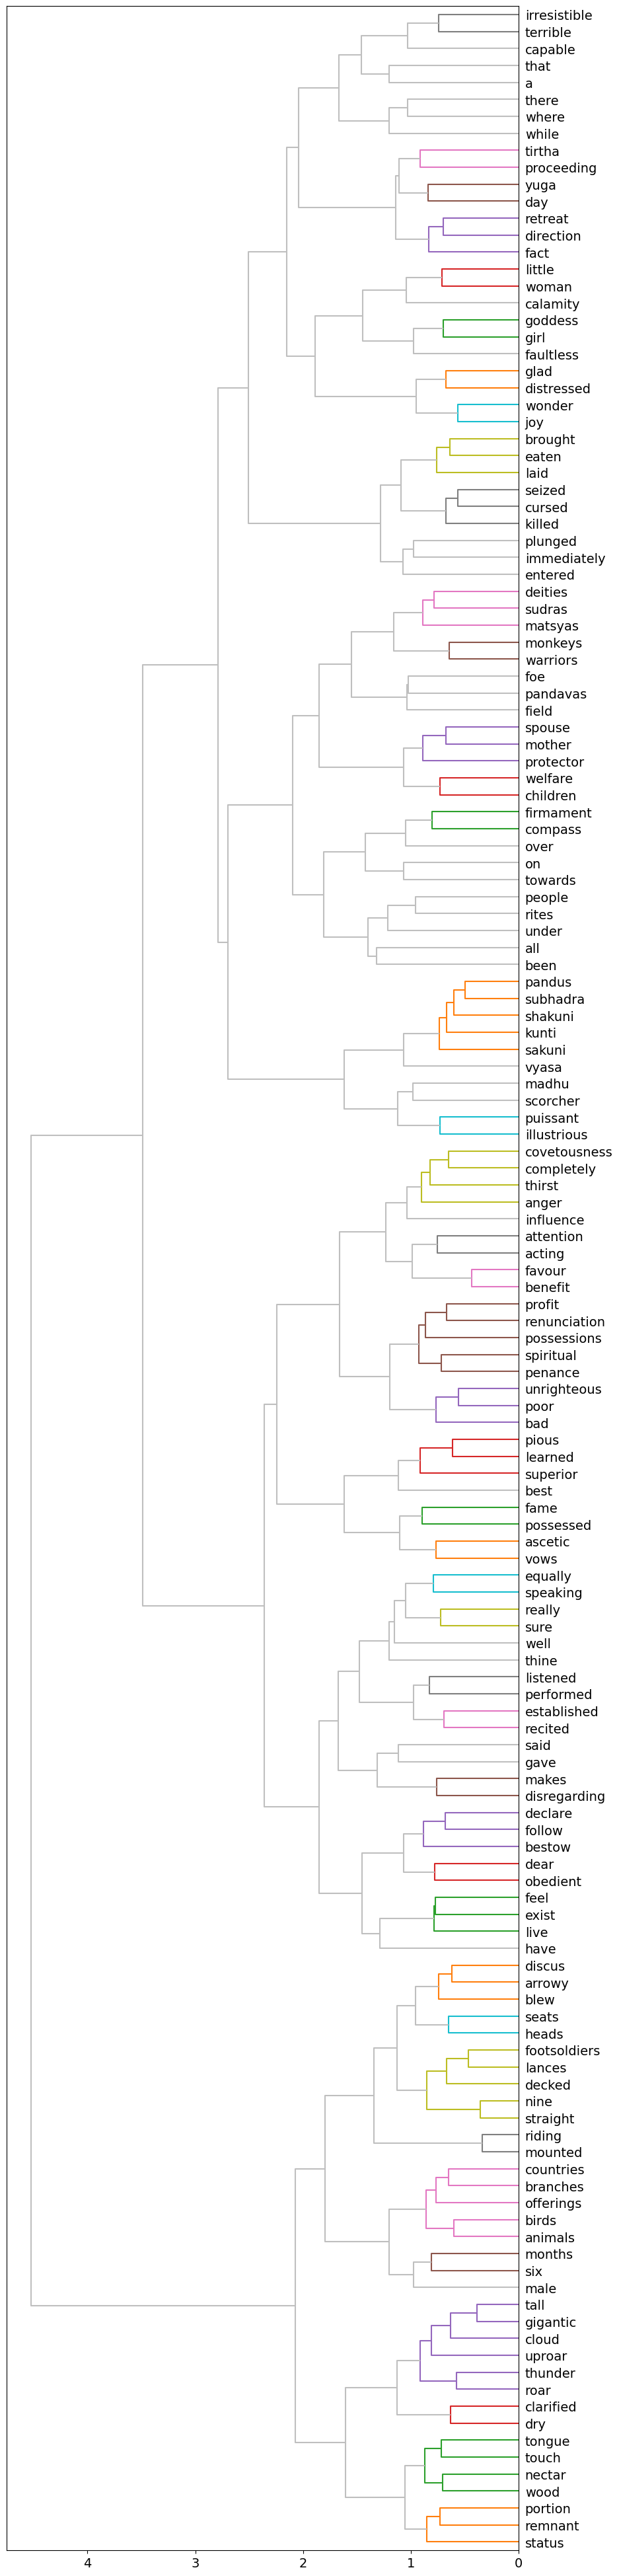

In [23]:
HAC(WV.sample(150)).plot()